In [1]:
using Pkg
Pkg.activate("C:\\Users\\Alex\\Desktop\\dynamical-systems\\env\\integrate\\")
using DifferentialEquations, StaticArrays, DynamicalSystems, CairoMakie, JLD

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
@inbounds U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
@inbounds σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
@inbounds g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )

@inbounds function TM(u, p, t)
    
    U_ = U(u[3], p)
    
    du1 = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) ) / p[2]
    du2 = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    return SVector(du1, du2, du3)
end

function output(idx, parameter, u0)
    println("index: $idx; I0: $parameter");flush(stdout)
    println("u0: $u0");flush(stdout)
end
function output(Λ, u0)
    println("Λ: $Λ");flush(stdout)
    println("last point: $u0");flush(stdout)
end
function separate()
    println("----------------");flush(stdout)
    println("  ");flush(stdout)
end

separate (generic function with 1 method)

In [3]:
time = 250
transient_time = 250
tstep = 0.001
trange = range(0.0, time, step = tstep);
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [4]:
const τ = 0.013;  const τD = 0.07993;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58;  const U0 = 0.3;  const ΔU0 = 0.305;

In [5]:
u0_start = [3.740482362235197, 0.8176653843010522, 0.4087238640418287]
I0range = range( -1.4, -1.709, length = 3000 )

-1.4:-0.00010303434478159386:-1.709

In [6]:
Λs =  zeros(length(I0range), 3)
u0s = zeros(length(I0range), 3);

In [7]:
for (idx, I0) in enumerate(I0range)

    if idx == 1
        global u0 = u0_start
    end

    #output(idx, I0, u0)

    p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
    ds = CoupledODEs(TM,  u0, p, diffeq = integ_set)

    tr, _ = trajectory(ds, 150.0, Δt = tstep; Ttr = transient_time)
    u0 = tr[end]; ds = CoupledODEs(TM,  u0, p, diffeq = integ_set)
    Λ = lyapunovspectrum(ds, time)
    Λs[idx, :] = Λ
    u0s[idx, :] = u0
    
    #output(Λs[idx, :], u0s[idx, :])
    #separate()
    
end

In [8]:
save("LSE U0=0.3 tauD.jld", "data", Λs)
save("u0s U0=0.3 tauD.jld", "data", u0s)

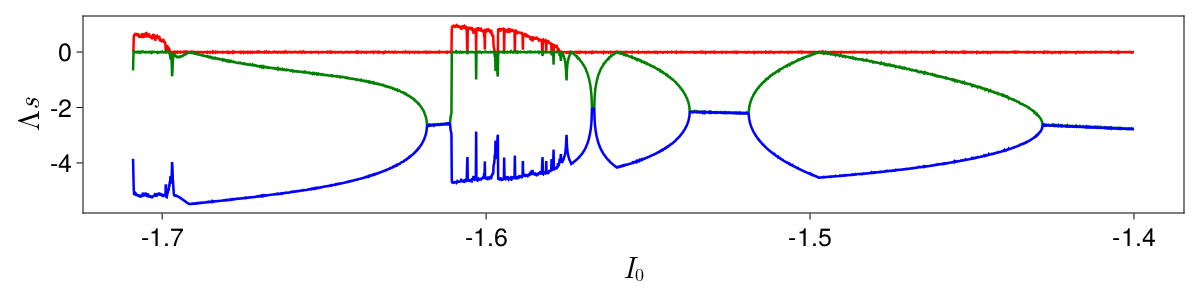

In [9]:
lb_size = 30; tck_size = 25;

f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"I_0", ylabel = L"\Lambda s",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)
lines!(axis, I0range, Λs[:, 1], linewidth = 2.5, color = :red)
lines!(axis, I0range, Λs[:, 2], linewidth = 2.5, color = :green)
lines!(axis, I0range, Λs[:, 3], linewidth = 2.5, color = :blue)
f